<a href="https://colab.research.google.com/github/naevs/AI-in-Finance/blob/main/Q1(Above_Risk_Free_Rate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, atpe, tpe, STATUS_OK, Trials
from keras.optimizers import Adam
#pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.expected_returns import returns_from_prices
from pypfopt import objective_functions
from pypfopt import risk_models, expected_returns
# Fetch daily data for 4 years
symbols=['AAPL', 'AMZN','GOOGL','META', 'MCD', 'GM', 'TSLA','PFE']
from datetime import datetime, timedelta

start_date = '2017-1-1'
end_date = '2023-12-31'
df = yf.download(symbols, start_date, end_date)['Adj Close']

# Download Risk-Free Rate data
rf_rate_symbol = '^IRX'
rf_rate_data = yf.download(rf_rate_symbol, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
dfa = df[df.index <= pd.Timestamp('2023-01-01')]

# Question 1a

Covariance Matrix:
 Ticker      AAPL      AMZN        GM     GOOGL       MCD      META       PFE  \
Ticker                                                                         
AAPL    0.001600  0.000916  0.000922  0.000882  0.000537  0.000944  0.000418   
AMZN    0.000916  0.001886  0.000640  0.001033  0.000353  0.001123  0.000303   
GM      0.000922  0.000640  0.003185  0.000949  0.000955  0.001023  0.000433   
GOOGL   0.000882  0.001033  0.000949  0.001383  0.000468  0.001094  0.000398   
MCD     0.000537  0.000353  0.000955  0.000468  0.000813  0.000418  0.000314   
META    0.000944  0.001123  0.001023  0.001094  0.000418  0.002566  0.000531   
PFE     0.000418  0.000303  0.000433  0.000398  0.000314  0.000531  0.001133   
TSLA    0.001556  0.001502  0.001937  0.001229  0.000882  0.001095  0.000542   

Ticker      TSLA  
Ticker            
AAPL    0.001556  
AMZN    0.001502  
GM      0.001937  
GOOGL   0.001229  
MCD     0.000882  
META    0.001095  
PFE     0.000542  
TSLA    

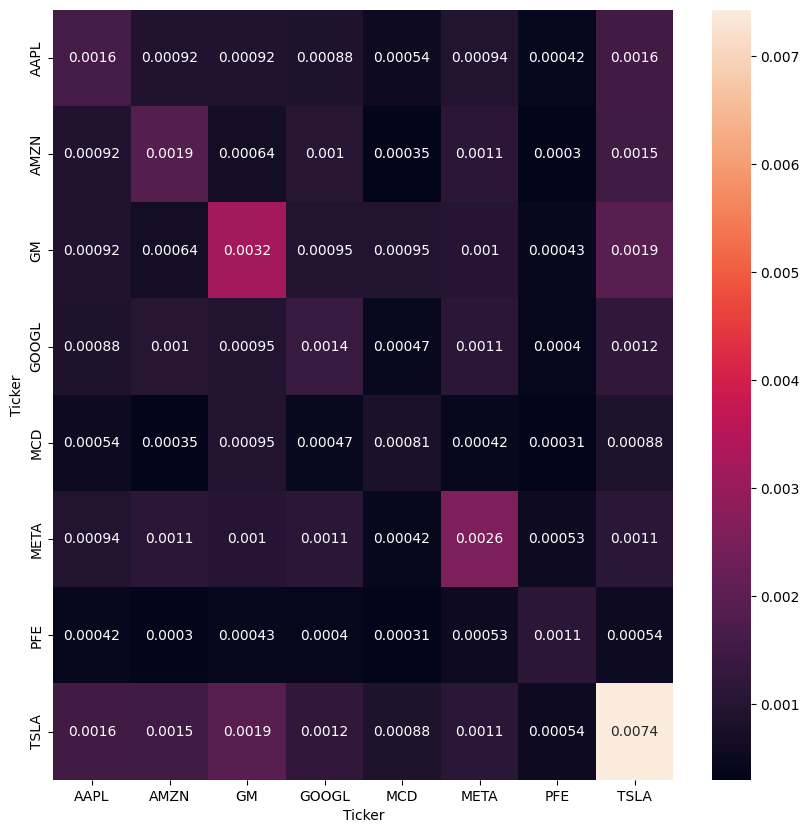

In [ ]:
# Calculate weekly returns
df_weekly_returns = dfa.resample('W').last().pct_change().dropna()

# Estimate the covariance matrix
covariance_matrix = df_weekly_returns.cov()
print("Covariance Matrix:\n", covariance_matrix)

plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, annot=True)
plt.show()

#Question 1b

In [ ]:
def prepare_data(stock_data, start_date, end_date):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
    forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')

    data_train = data_scaled[:forecast_start_idx - sequence_length]
    data_test = data_scaled[forecast_start_idx - sequence_length:forecast_end_idx + 1]

    train_generator = TimeseriesGenerator(data_train, data_train, length=sequence_length, batch_size=1)
    test_generator = TimeseriesGenerator(data_test, data_test, length=sequence_length, batch_size=1)

    X_train, y_train = zip(*[gen for gen in train_generator])
    X_test, y_test = zip(*[gen for gen in test_generator])

    X_train = np.squeeze(np.array(X_train), axis=1)
    y_train = np.squeeze(np.array(y_train), axis=1)
    X_test = np.squeeze(np.array(X_test), axis=1)
    y_test = np.squeeze(np.array(y_test), axis=1)

    return X_train, y_train, X_test, y_test, scaler


sequence_length = 60
X_train, y_train, X_test, y_test, scaler = prepare_data(df, start_date='2022-12-23', end_date='2022-12-31')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1385, 60, 1)
y_train shape: (1385, 1)
X_test shape: (5, 60, 1)
y_test shape: (5, 1)


<ipython-input-12-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-12-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


In [ ]:
def lstm_model(params):
    model = Sequential()
    model.add(LSTM(units=int(params['units']), input_shape=(60, 1), return_sequences=params['num_lstm_layers'] > 1))
    model.add(Dropout(params['dropout_rate']))

    for i in range(1, params['num_lstm_layers']):
        if i == params['num_lstm_layers'] - 1:
            model.add(LSTM(units=int(params['units']), return_sequences=False))
        else:
            model.add(LSTM(units=int(params['units']), return_sequences=True))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(1))
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0)
    model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0, callbacks=[early_stop])
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'units': hp.choice('units', [50, 100, 150]),
    'num_lstm_layers': hp.choice('num_lstm_layers', [1, 2, 3]),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

trials = Trials()
best = fmin(lstm_model, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best)

In [ ]:
#Best hyperparameters: {'batch_size': 1, 'dropout_rate': 0.14471559163933534, 'epochs': 2, 'learning_rate': 0.04054946189321238, 'num_lstm_layers': 0, 'units': 1}

In [ ]:
expected_returns = {symbol: (stock_forecasts[symbol][0] - stock_actual[symbol][0]) / stock_actual[symbol][0] for symbol in stock_forecasts}
print("Expected Returns:")
for symbol, expected_return in expected_returns.items():
    print(f"{symbol}: {expected_return:.4f}")

Expected Returns:
AAPL: 0.1056
AMZN: -0.0077
GOOGL: 0.2157
META: 0.4788
MCD: -0.0455
GM: 0.0054
TSLA: 0.5529
PFE: -0.0295


#Question 1c

In [ ]:
stock_forecasts = {}
stock_actual = {}

for symbol in symbols:
    print(f"Processing {symbol}")
    stock_data = df[symbol]

    X_train, y_train, X_test, y_test, scaler = prepare_data(stock_data, start_date='2023-1-1', end_date='2023-1-7')

    units = 100
    num_lstm_layers = 1
    dropout_rate = 0.14471559163933534
    learning_rate = 0.04054946189321238
    epochs = 150
    batch_size = 32

    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    if num_lstm_layers > 1:
        for _ in range(1, num_lstm_layers):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predict
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    stock_forecasts[symbol] = predictions[-1]
    stock_actual[symbol] = actual_prices[-1]
    model.reset_states()

In [ ]:
stock_actual

{'AAPL': array([128.73522949]),
 'AMZN': array([86.08000183]),
 'GOOGL': array([87.33999634]),
 'META': array([129.88220215]),
 'MCD': array([262.01358032]),
 'GM': array([35.42432404]),
 'TSLA': array([113.05999756]),
 'PFE': array([47.9877739])}

In [ ]:
stock_forecasts

{'AAPL': array([142.33076], dtype=float32),
 'AMZN': array([85.41302], dtype=float32),
 'GOOGL': array([106.175095], dtype=float32),
 'META': array([192.0756], dtype=float32),
 'MCD': array([250.08617], dtype=float32),
 'GM': array([35.615482], dtype=float32),
 'TSLA': array([175.5682], dtype=float32),
 'PFE': array([46.56995], dtype=float32)}

In [ ]:
weekly_rf_rate = rf_rate_data['2023-01-03']
weekly_rf_rate = weekly_rf_rate/100
weekly_rf_rate = weekly_rf_rate.mean()
weekly_rf_rate

0.04255000114440918

In [ ]:
dfa = df[df.index <= pd.Timestamp('2022-12-31')]
df_weekly = dfa.resample('W').last()
df_weekly_returns = df_weekly.pct_change().dropna()
cov_matrix = df_weekly_returns.cov()

expected_returns_list = pd.Series({
    'AAPL': 0.1056,
    'AMZN': -0.0077,
    'GM': 0.0054,
    'GOOGL': 0.2157,
    'MCD': -0.0455,
    'META': 0.4788,
    'PFE': -0.0295,
    'TSLA': 0.5529,
})
ef = EfficientFrontier(expected_returns_list, cov_matrix, weight_bounds=(0, 1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
cleaned_weights = ef.max_sharpe(risk_free_rate=weekly_rf_rate)

cleaned_weights = ef.clean_weights()

print("Optimized Portfolio Weights:")
print(cleaned_weights)

ef.portfolio_performance(verbose=True, risk_free_rate=weekly_rf_rate)

Optimized Portfolio Weights:
OrderedDict([('AAPL', 0.04526), ('AMZN', 0.0), ('GM', 0.0), ('GOOGL', 0.14611), ('MCD', 0.0), ('META', 0.38148), ('PFE', 0.0), ('TSLA', 0.42715)])
Expected annual return: 45.5%
Annual volatility: 5.0%
Sharpe Ratio: 8.25


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


(0.4551190457884588, 0.04998775965215308, 8.253401382957946)

# Question 1d

In [ ]:
initial_prices = {symbol: df[symbol]['2022-12-30'] for symbol in symbols}
actual_returns = {symbol: (stock_actual[symbol][0] - initial_prices[symbol]) / initial_prices[symbol] for symbol in symbols}
portfolio_actual_return = sum(cleaned_weights[symbol] * actual_returns[symbol] for symbol in symbols)
print(f"Portfolio's actual rate of return for the first week of January 2023: {portfolio_actual_return:.4f}")

Portfolio's actual rate of return for the first week of January 2023: -0.0060


In [ ]:
equal_weight_return = sum(actual_returns.values()) / len(actual_returns)
print(f"Equally weighted portfolio's rate of return for the first week: {equal_weight_return:.4f}")

Equally weighted portfolio's rate of return for the first week: 0.0118


# Question 1e

In [ ]:
symbols = ['AAPL', 'AMZN', 'GM', 'GOOGL', 'MCD', 'META', 'PFE', 'TSLA']
portfolio_performance_records = []
equally_weighted_performance_records = []
error_dates = []

def record_performance(date, portfolio_return, equally_weighted_return, error_occurred):
    portfolio_performance_records.append((date, portfolio_return, error_occurred))
    equally_weighted_performance_records.append((date, equally_weighted_return, error_occurred))

start_date = datetime(2023, 1, 2)
end_date = datetime(2023, 12, 31)

def run_weekly_forecasts(start_date, end_date):
    current_date = start_date
    while current_date <= end_date:
        error_occurred = False
        if current_date.strftime('%Y-%m-%d') in rf_rate_data.index:
            weekly_rf_rate = rf_rate_data.loc[current_date.strftime('%Y-%m-%d')] / 100
            weekly_rf_rate = weekly_rf_rate.mean()
        else:
            weekly_rf_rate = rf_rate_data['2023']/ 100
            weekly_rf_rate = weekly_rf_rate.mean()

        expected_returns = {}
        actual_returns = {}

        for symbol in symbols:
            stock_data = df[symbol]

            X_train, y_train, X_test, y_test, scaler = prepare_data(stock_data, current_date, current_date + timedelta(weeks=1))

            units = 100
            num_lstm_layers = 1
            dropout_rate = 0.14471559163933534
            learning_rate = 0.04054946189321238
            epochs = 2
            batch_size = 32

            model = Sequential()
            model.add(LSTM(units, input_shape=(sequence_length, 1), return_sequences=True))
            model.add(Dropout(dropout_rate))
            if num_lstm_layers > 1:
                for _ in range(1, num_lstm_layers):
                    model.add(LSTM(units, return_sequences=True))
                    model.add(Dropout(dropout_rate))
            model.add(LSTM(units, return_sequences=False))
            model.add(Dropout(dropout_rate))
            model.add(Dense(1))

            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mean_squared_error')

            model.summary()

            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

            predictions_scaled = model.predict(X_test)
            predictions = scaler.inverse_transform(predictions_scaled)[-1]
            actual = scaler.inverse_transform(y_test.reshape(-1, 1))[-1]

            expected_return = (predictions - actual) / actual

            expected_returns[symbol] = expected_return

            actual_returns[symbol] = (actual - scaler.inverse_transform(X_test[-1, -1].reshape(-1, 1))[0]) / scaler.inverse_transform(X_test[-1, -1].reshape(-1, 1))[0]

        df_weekly = df[df.index <= pd.Timestamp(current_date.strftime('%Y-%m-%d'))].resample('W').last()
        df_weekly_returns = df_weekly.pct_change().dropna()
        cov_matrix = df_weekly_returns.cov()
        print('uoutput')
        print(weekly_rf_rate)
        print(expected_returns)
        try:
            ef = EfficientFrontier(pd.Series(expected_returns), cov_matrix, weight_bounds=(0, 1))
            ef.add_objective(objective_functions.L2_reg, gamma=0.1)
            weights = ef.max_sharpe(risk_free_rate=weekly_rf_rate)
            cleaned_weights = ef.clean_weights()
        except Exception as e:
            print(f"Encountered an optimization error on {current_date}: {e}. Opting for an equal weighting strategy.")
            cleaned_weights = {symbol: 1/len(symbols) for symbol in symbols}  # Use equal weighting as fallback
            error_dates.append(current_date)  # Log the date of the error
            error_occurred = True

        optimized_portfolio_return = np.dot(list(cleaned_weights.values()), list(actual_returns.values()))
        equally_weighted_return = np.mean(list(actual_returns.values()))

        record_performance(current_date, optimized_portfolio_return, equally_weighted_return, error_occurred=error_occurred)

        current_date += timedelta(weeks=1)

run_weekly_forecasts(start_date, end_date)

In [ ]:
portfolio_performance_records

[(datetime.datetime(2023, 1, 2, 0, 0), array([0.0033465]), False),
 (datetime.datetime(2023, 1, 9, 0, 0), array([-0.00507494]), False),
 (datetime.datetime(2023, 1, 16, 0, 0), array([0.03327247]), False),
 (datetime.datetime(2023, 1, 23, 0, 0), array([-0.02738336]), False),
 (datetime.datetime(2023, 1, 30, 0, 0), array([-0.00972021]), False),
 (datetime.datetime(2023, 2, 6, 0, 0), array([0.01977257]), False),
 (datetime.datetime(2023, 2, 13, 0, 0), array([-0.00546984]), False),
 (datetime.datetime(2023, 2, 20, 0, 0), array([0.0027941]), False),
 (datetime.datetime(2023, 2, 27, 0, 0), array([0.0023578]), False),
 (datetime.datetime(2023, 3, 6, 0, 0), array([0.008603]), False),
 (datetime.datetime(2023, 3, 13, 0, 0), array([0.00285405]), False),
 (datetime.datetime(2023, 3, 20, 0, 0), array([0.0141524]), False),
 (datetime.datetime(2023, 3, 27, 0, 0), array([-0.00490379]), True),
 (datetime.datetime(2023, 4, 3, 0, 0), array([-0.00297203]), False),
 (datetime.datetime(2023, 4, 10, 0, 0), 

In [ ]:
equally_weighted_performance_records

[(datetime.datetime(2023, 1, 2, 0, 0), 0.0030271967740015714, False),
 (datetime.datetime(2023, 1, 9, 0, 0), 0.0008982178148274595, False),
 (datetime.datetime(2023, 1, 16, 0, 0), 0.02254231393683833, False),
 (datetime.datetime(2023, 1, 23, 0, 0), -0.026258757549756904, False),
 (datetime.datetime(2023, 1, 30, 0, 0), -0.0015839450257647486, False),
 (datetime.datetime(2023, 2, 6, 0, 0), 0.011375969722532239, False),
 (datetime.datetime(2023, 2, 13, 0, 0), 0.0034426128879974484, False),
 (datetime.datetime(2023, 2, 20, 0, 0), 0.0066500394838193465, False),
 (datetime.datetime(2023, 2, 27, 0, 0), -0.0010723761306799505, False),
 (datetime.datetime(2023, 3, 6, 0, 0), 0.005770924081923045, False),
 (datetime.datetime(2023, 3, 13, 0, 0), 0.008216004441667523, False),
 (datetime.datetime(2023, 3, 20, 0, 0), -0.0028142678253226423, False),
 (datetime.datetime(2023, 3, 27, 0, 0), -0.004903790347229185, True),
 (datetime.datetime(2023, 4, 3, 0, 0), -9.129218627079038e-05, False),
 (datetime.da

# Question 1f, g

In [ ]:
portfolio_df = pd.DataFrame(portfolio_performance_records, columns=['Date', 'Optimized Portfolio Return', 'error_occurred'])
equally_weighted_df = pd.DataFrame(equally_weighted_performance_records, columns=['Date', 'Equally Weighted Portfolio Return', 'error_occurred'])

# Calculate mean and standard deviation for the optimized portfolio
optimized_mean = portfolio_df['Optimized Portfolio Return'].mean()
optimized_std = portfolio_df['Optimized Portfolio Return'].std()

# Calculate mean and standard deviation for the equally weighted portfolio
equally_weighted_mean = equally_weighted_df['Equally Weighted Portfolio Return'].mean()
equally_weighted_std = equally_weighted_df['Equally Weighted Portfolio Return'].std()

# Print results
print(f"Optimized Portfolio - Mean: {optimized_mean}, Std: {optimized_std}")
print(f"Equally Weighted Portfolio - Mean: {equally_weighted_mean}, Std: {equally_weighted_std}")

Optimized Portfolio - Mean: [0.00317719], Std: 0.01315605068319014
Equally Weighted Portfolio - Mean: 0.003197968065185625, Std: 0.0092286996847664


#Question 1h

##Analysis
###Return:
The equally weighted portfolio has a higher mean return than the optimized portfolio. This suggests that, over the period analyzed, spreading investments equally across all assets without attempting to optimize based on forecasted returns and covariances yielded better returns.
###Risk (Volatility):
The optimized portfolio exhibits higher volatility compared to the equally weighted portfolio. This higher risk did not translate into higher returns for the period in question, which might be counterintuitive to what one would expect from an optimized portfolio aiming to maximize the Sharpe ratio.
##Implications
###Risk-Return Trade-off:
Typically, investors seek to maximize returns for a given level of risk or minimize risk for a given level of returns. In this scenario, the equally weighted portfolio offered a better risk-return trade-off, with higher returns for lower risk.
###Optimization Considerations:
The result could imply several things; perhaps the assumptions behind the optimization (like the efficiency of the markets or the accuracy of the forecasted returns) did not hold, or the optimization was more sensitive to the input data than expected, leading to suboptimal risk-return characteristics.
###Diversification:
The equally weighted portfolio inherently benefits from diversification, which might have helped in reducing its volatility. The optimized portfolio, depending on the weights assigned, might have been less diversified or exposed to specific risks not fully captured in the optimization process.

##Risk free rate's impact on Optimized Portfolio
###Shifts the Efficient Frontier:
A higher risk-free rate increases the slope of the capital allocation line (CAL), potentially altering the optimal asset mix to favor lower-risk investments if the expected return on riskier assets doesn't sufficiently compensate for their additional risk.
###Raises the Threshold for Investment:
When the risk-free rate is high, the expected return threshold for including a risky asset in the portfolio also increases. Assets must offer a significantly higher expected return to justify their inclusion and weighting in the optimized portfolio, given the risk-free alternative.
###Influences Sharpe Ratio:
The Sharpe ratio is calculated as the excess return of the portfolio over the risk-free rate divided by the portfolio's standard deviation. A higher risk-free rate could therefore make it more challenging for the portfolio to achieve a high Sharpe ratio, affecting the portfolio optimization process that aims to maximize this metric.
###Given the higher risk-free rate, it's plausible that:

The optimized portfolio may have been constrained to select positions that, while theoretically offering the best risk-adjusted returns above the high risk-free rate, did not actually perform as well as expected. This could lead to lower realized returns and potentially higher volatility if the selected assets were also riskier.
The equally weighted portfolio, not being bound by these optimization constraints and potentially more diversified, might have benefited from unexpected gains in assets that the optimization process viewed as less favorable due to their risk-return profile relative to the high risk-free rate.